In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import os
import analysis_marisol as am
from analysis_marisol import fit_data_to_polynomial, find_V_floating, Vplasma_from_model, get_j_i_star, find_Te_fit, find_Te_n_e_iteration
from constants import e, k, m_i, mu, A_probe, r_p, l_p, k_eV, K_to_eV, m_e

# Set style for better-looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

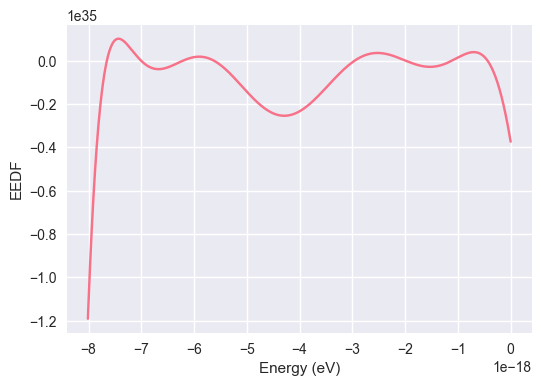

In [9]:
def get_eedf(file):
    #only using I_e
    Te, ne, I_e = find_Te_n_e_iteration(file)
    I_e = np.array(I_e)
    ## Only using V and V_plasma
    I, V, coeffs, model = fit_data_to_polynomial(file)
    V_plasma, Iplasma, min_d2I, info = Vplasma_from_model(model, V)
    
    
    coeffs_I_e = np.polyfit(V, I_e, deg=11)
    model_I_e = np.poly1d(coeffs_I_e)
    d2I_edV2 = np.polyder(model_I_e,2)
    y2 = d2I_edV2(V)

    # Calculate the eedf
    eedf = (-4/(A_probe*e**2))*np.sqrt((m_e*np.abs(V_plasma - V[200])/(2*e)))*y2
    
    return eedf, e*(V_plasma - V)

path = '/Users/marisolvelapatino/Desktop/Langmuir-Probe/LP/10 mTorr/1000W/Trace_16p6mTorr_1000W_3.csv'
y, x = get_eedf(path)
plt.figure(figsize=(6,4))
plt.plot(x, y)
plt.xlabel("Energy (eV)")
plt.ylabel("EEDF")
plt.show()


Found V_plasma:  16.229948600833342  V , with V floating :  4.172219505071426
Found V_plasma:  16.229948600833342  V , with V floating :  4.172219505071426
Te at iteration  0  is  60833.200887664374
No exact match. Closest X value: 3.0, j_i_star = 2.503379063
Te at iteration  1  is  30160.756902191668
n_e at iteration  1  is  2.0567675264879027e+17
I_e at iteration  1  is  1e-07
No exact match. Closest X value: 0.0, j_i_star = 3.547241599
Te at iteration  2  is  30142.331943863748
n_e at iteration  2  is  51551527218558.96
I_e at iteration  2  is  1e-07
No exact match. Closest X value: 0.0, j_i_star = 3.547241599
Te at iteration  3  is  30142.33030116299
n_e at iteration  3  is  36392347993160.945
I_e at iteration  3  is  1e-07
No exact match. Closest X value: 0.0, j_i_star = 3.547241599
Te at iteration  4  is  30142.33030116299
T_e found to be:  30142.33030116299
T_e in eV found to be:  2.5974650550277296
n_e found to be:  36.392348984818454 e12 m^-3


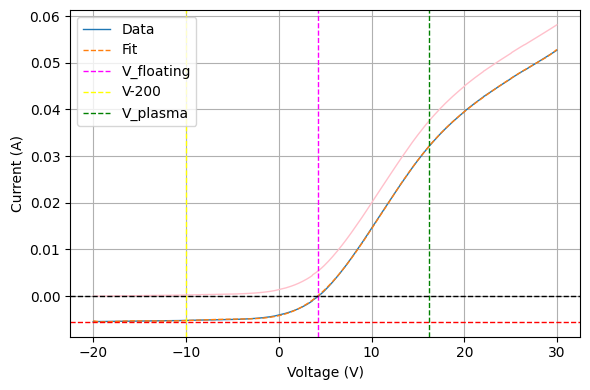

In [2]:
path = '/Users/marisolvelapatino/Desktop/Langmuir-Probe/Trace_98p5mTorr_1000W_4.csv'


## Model data with a polynomial fit.
I, V, coeffs, model = fit_data_to_polynomial(path)

## Find the floating potential
V_floating = find_V_floating(coeffs, domain=(min(V), max(V)))

## Find the plasma potential
V_plasma, Iplasma, min_d2I, info = Vplasma_from_model(model, V)

print("Found V_plasma: ", V_plasma, " V , with V floating : ", V_floating)


def routine(path):
    I, V, coeffs, model = fit_data_to_polynomial(path)

    ## Find the floating potential
    V_floating = find_V_floating(coeffs, domain=(min(V), max(V)))

    ## Find the plasma potential
    V_plasma, Iplasma, min_d2I, info = Vplasma_from_model(model, V)

    print("Found V_plasma: ", V_plasma, " V , with V floating : ", V_floating)

    # Variables
    n_e = 0
    T_e = 0
    I_ion = None
    j_i_star = 0
    #i = 0
    for i in range(2):
        #get initial ion current:
        if i == 0:
            I_ion = I[20]
            
            I_e = I - I_ion
            
            T_e = find_Te(I_e, V, V_plasma)
            T_e_eV = T_e*K_to_eV #in eV
            print(f"Te found to be {T_e} K")
            print(f"Te found to be {T_e_eV} eV")
            n_e = 1.05e15*np.sqrt(mu/T_e_eV)*I_e[200]/(A_probe)
            print(f"ne found to be {n_e} m^-3")

            # Calculate lambdaD:
            lambda_D = 7430*np.sqrt(T_e_eV/n_e)
            print(f"lambdaD found to be {lambda_D} m")

            ratio = (r_p/lambda_D) #TODO Temporal fix is to take the mean of the ratios
            print(f"ratio found to be {ratio}")

            # Calculate j_i_star:
            Xp_star = e*(V_plasma - V[200])/(k*T_e)
            print(f"Xp_star found to be {Xp_star}")
            j_i_star = get_j_i_star(ratio, Xp_star)
            print("j_i_star found to be: ", j_i_star)

            # Calculate I_ion:
            #I_ion = 0.25*e*n_e*(np.sqrt(8*k*T_e/(np.pi*m_i)))*A_probe*j_i_star
            #print("I_ion found to be: ", I_ion)
            #return V_plasma, V_floating, T_e, n_e, j_i_star, I_ion
        else:
            
            I_ion = 0.25*e*n_e*(np.sqrt(8*k*T_e/(np.pi*m_i)))*A_probe*j_i_star
            I_e = I - I_ion
            n_e = 1.05e15*np.sqrt(mu/T_e_eV)*I_e[200]/(A_probe*j_i_star) # TODO: Check if this is correct
            T_e = find_Te(I_e, V, V_plasma)
            T_e_eV = T_e*K_to_eV #in eV
            lambda_D = 7430*np.sqrt(T_e_eV/n_e)
            ratio = (r_p/lambda_D)
            Xp_star = e*(V_plasma - V[200])/(k*T_e)
            j_i_star = get_j_i_star(ratio, Xp_star)

        

#V_plasma, V_floating, T_e, n_e, j_i_star, I_ion = routine(path)
T_e, n_e = find_Te_n_e_iteration(path)
print("T_e found to be: ", T_e)
print("T_e in eV found to be: ", T_e*K_to_eV)
print("n_e found to be: ", n_e/1e12, "e12 m^-3")
plt.figure(figsize=(6,4))

plt.plot(V, I, '-', lw=1 , label='Data')

I_hat = model(V)
plt.plot(V, I_hat, '--', lw=1, label='Fit')


plt.axhline(y=I[20], color='red', linestyle='--', lw=1)
plt.plot(V, I - I[20], '-', color='pink', lw=1)

plt.axvline(x=V_floating, color='magenta', linestyle='--', lw=1, label='V_floating')
plt.axvline(x=V[200], color='yellow', linestyle='--', lw=1, label='V-200')
plt.axvline(x=V_plasma, color='green', linestyle='--', lw=1, label='V_plasma')
#plt.axvline(x=0, color='black', linestyle='--', lw=1)
plt.axhline(y=0, color='black', linestyle='--', lw=1)

plt.xlabel("Voltage (V)")
plt.ylabel("Current (A)")
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.ylim(-1e-5, 1e-6)  for I_e any negative value is set to 1e-7
#plt.xlim(-21, -17.5)
plt.show()

